In [1]:
import pandas as pd
import seaborn as sns
import pdb

In [2]:
df_vax = pd.read_csv('./2019VAERSVAX.csv')

In [3]:
df_sym = pd.read_csv('./2019VAERSDATA.csv', encoding='cp1252')

In [4]:
df_sym.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,794156,1/1/19,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,...,none,none,NaN,NaN,2,1/1/19,NaN,Y,NaN,tetracycline
1,794157,1/1/19,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,...,None,Hypothryoidism,Arm soreness at site of injection,NaN,2,1/1/19,NaN,NaN,NaN,None
2,794158,1/1/19,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,...,None,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,None
3,794159,1/1/19,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin
4,794160,1/1/19,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,1/1/19,NaN,Y,Y,ACE INHIBITORS


In [5]:
df_vax.merge(df_sym, left_on='VAERS_ID' , right_on='VAERS_ID')
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,794156,FLU4,GLAXOSMITHKLINE BIOLOGICALS,JZ3B7,UNK,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT)
1,794157,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
2,794158,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
3,794159,DTAPIPV,GLAXOSMITHKLINE BIOLOGICALS,G9P35,1,IM,LL,DTAP + IPV (KINRIX)
4,794159,MMRV,MERCK & CO. INC.,R015744,1,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD)


In [6]:
finaldata = df_vax.merge(df_sym, left_on='VAERS_ID' , right_on='VAERS_ID')

In [7]:
finaldata['VAX_MANU'].value_counts()

GLAXOSMITHKLINE BIOLOGICALS          2596
MERCK & CO. INC.                     1746
SANOFI PASTEUR                        976
SEQIRUS, INC.                         710
PFIZER\WYETH                          358
UNKNOWN MANUFACTURER                  323
NOVARTIS VACCINES AND DIAGNOSTICS     182
PROTEIN SCIENCES CORPORATION           31
CSL LIMITED                            21
EMERGENT BIOSOLUTIONS                  20
MEDIMMUNE VACCINES, INC.               14
BERNA BIOTECH, LTD.                    10
MASS. PUB HLTH BIOL LAB                 6
INTERCELL AG                            6
DYNAVAX TECHNOLOGIES CORPORATION        5
PAXVAX                                  3
TEVA PHARMACEUTICALS                    2
MICHIGAN DEPT PUB HLTH                  1
Name: VAX_MANU, dtype: int64

In [8]:
finaldata['VAX_ROUTE'].value_counts()

IM     3584
UN     1757
SYR     679
SC      323
PO      106
OT       37
IN       15
ID       14
Name: VAX_ROUTE, dtype: int64

IM=intramuscular injection ; UN=unknow site injection ; SYR=    ; SC=subcutaneous injection ; PO=  ; OT=Other ;  IN=intranasal ; ID

Text(0, 0.5, 'Count')

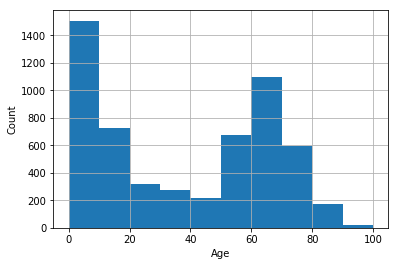

In [21]:
import matplotlib.pyplot as plt 
finaldata['AGE_YRS'].hist(bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
#newdf = finaldata['AGE_YRS'].value_counts()
#range of age and histo

In [22]:
finaldata=finaldata.set_index('VAERS_ID')
finaldata.head()

,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,RECVDATE,STATE,AGE_YRS,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
794156,FLU4,GLAXOSMITHKLINE BIOLOGICALS,JZ3B7,UNK,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT),1/1/19,NaN,69.0,...,none,none,NaN,NaN,2,1/1/19,NaN,Y,NaN,tetracycline
794157,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),1/1/19,IL,68.0,...,None,Hypothryoidism,Arm soreness at site of injection,NaN,2,1/1/19,NaN,NaN,NaN,None
794158,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),1/1/19,MA,62.0,...,None,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,None
794159,DTAPIPV,GLAXOSMITHKLINE BIOLOGICALS,G9P35,1,IM,LL,DTAP + IPV (KINRIX),1/1/19,UT,5.0,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin
794159,MMRV,MERCK & CO. INC.,R015744,1,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD),1/1/19,UT,5.0,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin


In [23]:
corr = finaldata.corr()
corr.style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3) # 'coolwarm', RdBu_r', & 'BrBG' good color maps

,AGE_YRS,CAGE_YR,CAGE_MO,HOSPDAYS,NUMDAYS,FORM_VERS
AGE_YRS,1,1,0.0587,0.282,-0.0414,0.0437
CAGE_YR,1,1,-0.268,0.29,-0.0417,0.0259
CAGE_MO,0.0587,-0.268,1,-0.147,-0.0522,-0.157
HOSPDAYS,0.282,0.29,-0.147,1,0.168,-0.192
NUMDAYS,-0.0414,-0.0417,-0.0522,0.168,1,0.000575
FORM_VERS,0.0437,0.0259,-0.157,-0.192,0.000575,1


In [24]:
selection=['VAX_MANU','VAX_ROUTE','VAX_SITE','VAX_NAME','AGE_YRS','ER_VISIT']
cutfinaldata=pd.DataFrame(finaldata,columns=selection)
cutfinaldata.head()

,VAX_MANU,VAX_ROUTE,VAX_SITE,VAX_NAME,AGE_YRS,ER_VISIT
VAERS_ID,,,,,,
794156,GLAXOSMITHKLINE BIOLOGICALS,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT),69.0,NaN
794157,GLAXOSMITHKLINE BIOLOGICALS,NaN,NaN,ZOSTER (SHINGRIX),68.0,NaN
794158,GLAXOSMITHKLINE BIOLOGICALS,NaN,NaN,ZOSTER (SHINGRIX),62.0,NaN
794159,GLAXOSMITHKLINE BIOLOGICALS,IM,LL,DTAP + IPV (KINRIX),5.0,NaN
794159,MERCK & CO. INC.,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD),5.0,NaN


In [25]:
cutfinaldata.count()

VAX_MANU     7010
VAX_ROUTE    6515
VAX_SITE     6233
VAX_NAME     7010
AGE_YRS      5613
ER_VISIT       70
dtype: int64

ER visit (not collected or not needed) and no way it was reported 

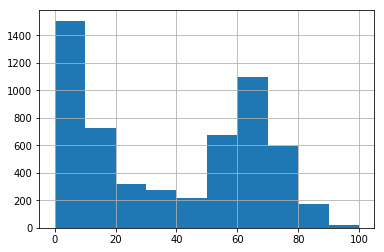

In [26]:
cutfinaldata['AGE_YRS'].hist(bins=10)

In [27]:
cutfinaldata.dtypes

VAX_MANU      object
VAX_ROUTE     object
VAX_SITE      object
VAX_NAME      object
AGE_YRS      float64
ER_VISIT      object
dtype: object

In [28]:
cutfinaldata['VAX_MANU']=cutfinaldata['VAX_MANU'].astype('category').cat.codes
cutfinaldata['VAX_ROUTE']=cutfinaldata['VAX_ROUTE'].astype('category').cat.codes
cutfinaldata['VAX_SITE']=cutfinaldata['VAX_SITE'].astype('category').cat.codes
cutfinaldata['VAX_NAME']=cutfinaldata['VAX_NAME'].astype('category').cat.codes
cutfinaldata['ER_VISIT']=cutfinaldata['ER_VISIT'].astype('category').cat.codes

In [29]:
cutfinaldata.dtypes

VAX_MANU        int8
VAX_ROUTE       int8
VAX_SITE        int8
VAX_NAME        int8
AGE_YRS      float64
ER_VISIT        int8
dtype: object

In [30]:
corr2=cutfinaldata.corr()
corr2.style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)
# 'coolwarm', RdBu_r', & 'BrBG' good color maps
#slight correlation between age and vax_name, which makes sense as many vaccines are given based on age type
#could show a stronger correlation if data is cleaner 

,VAX_MANU,VAX_ROUTE,VAX_SITE,VAX_NAME,AGE_YRS,ER_VISIT
VAX_MANU,1,0.0322,0.0471,-0.419,-0.282,0.00944
VAX_ROUTE,0.0322,1,0.455,0.0619,-0.111,0.0144
VAX_SITE,0.0471,0.455,1,-0.0653,-0.192,-0.00401
VAX_NAME,-0.419,0.0619,-0.0653,1,0.535,-0.0442
AGE_YRS,-0.282,-0.111,-0.192,0.535,1,-0.026
ER_VISIT,0.00944,0.0144,-0.00401,-0.0442,-0.026,1
